## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

# *DATASET IMPORT & EDA*

In [1]:
#basics
import pandas as pd
import numpy as np
import pickle

#nlp
import spacy
import string
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn.neighbors import NearestNeighbors

#viz
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, TimeDistributed, Flatten, Dropout
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import Precision, Recall 
from sklearn.utils import resample
from sklearn.metrics import multilabel_confusion_matrix, classification_report





BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [3]:
#check for N/A values to drop
df.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64

In [4]:
#define the comments texts
df_comments=df["comment_text"]
comments=df_comments.values

In [5]:
#define the labels
df_toxic_comments_labels=df[["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]]
toxic_comments_labels=df_toxic_comments_labels.values

In [6]:
#number of toxic comments per label
df_toxic_comments_labels.sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

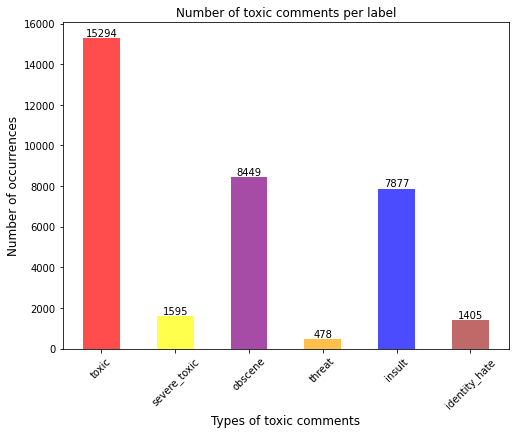

In [7]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+100, y[i], ha = 'center')

toxic_labels_names=["toxic",	"severe_toxic",	"obscene",	"threat",	"insult",	"identity_hate"]
fig = plt.figure(figsize=(8,6))
c = ['red', 'yellow', 'purple', 'orange', 'blue',"brown"]
plt.xticks(rotation=45, ha="center")
plt.title("Number of toxic comments per label")
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Types of toxic comments', fontsize=12)
addlabels(toxic_labels_names, sum(toxic_comments_labels))

plt.bar(toxic_labels_names,sum(toxic_comments_labels),width=0.5,color=c,alpha=0.7);

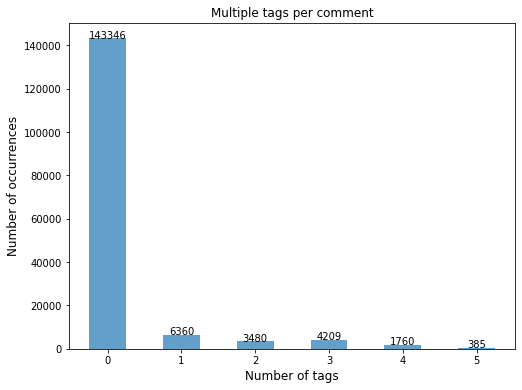

In [8]:
y=[]
for i in range(len(toxic_labels_names)):
  y.append(len(df["sum_injurious"][df["sum_injurious"]==i]))

fig = plt.figure(figsize=(8,6))
plt.xticks(ha="center")
plt.title("Multiple tags per comment")
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)
addlabels(np.arange(0,6), y)

plt.bar(np.arange(0,6),y,width=0.5,alpha=0.7);

In [9]:
#examples...
for label in toxic_labels_names:
  print('\033[1m' + label.upper() + '\033[0m')
  print(df['comment_text'][df[label]==1].iloc[1])
  print(' ')

  print('******************************************************************')

TOXIC
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
 
******************************************************************
SEVERE_TOXIC
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
 
******************************************************************
OBSCENE
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead g

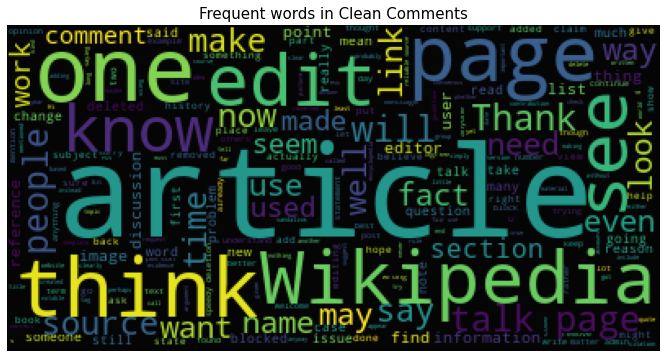

In [10]:
stopword=set(STOPWORDS)

subset=df[df["sum_injurious"]==0]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(12,6))
plt.axis("off")
plt.title("Frequent words in Clean Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

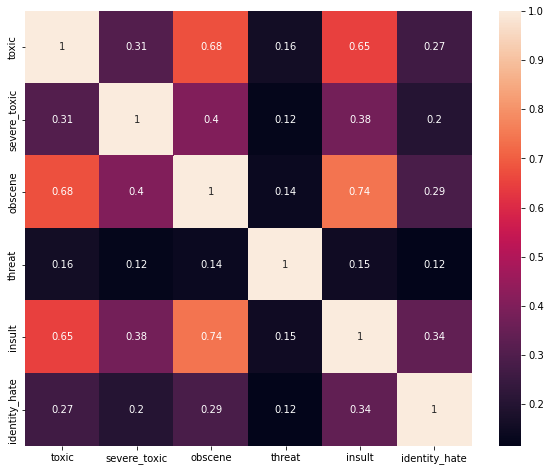

In [11]:
#correlation matrix
corr=df.iloc[:,1:-1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

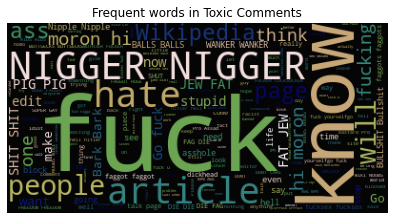

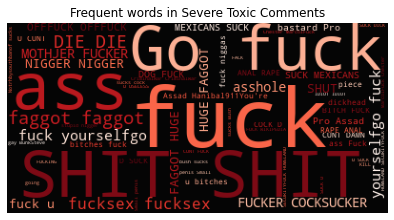

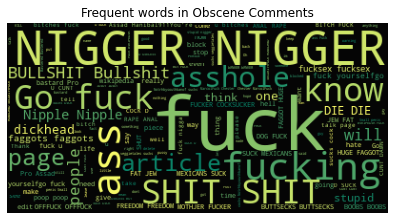

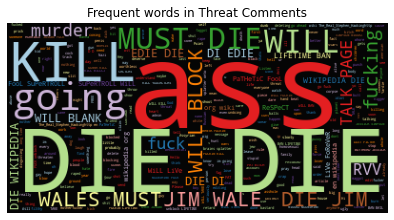

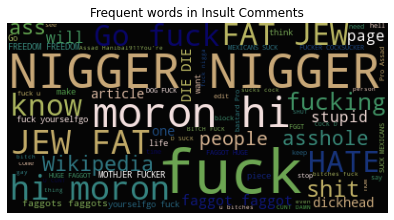

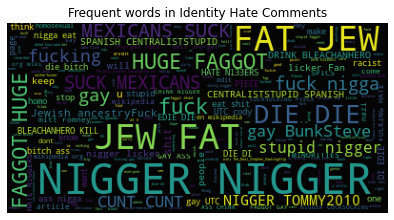

In [12]:
subset=df[df.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.axis("off")
plt.title("Frequent words in Toxic Comments", fontsize=12)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=17), alpha=0.98)

subset=df[df.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(3,2,2)
plt.axis("off")
plt.title("Frequent words in Severe Toxic Comments", fontsize=12)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=17), alpha=0.98)

subset=df[df.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(3,2,3)
plt.axis("off")
plt.title("Frequent words in Obscene Comments", fontsize=12)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=17), alpha=0.98)

subset=df[df.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(3,2,4)
plt.axis("off")
plt.title("Frequent words in Threat Comments", fontsize=12)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=17), alpha=0.98)

subset=df[df.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(3,2,5)
plt.axis("off")
plt.title("Frequent words in Insult Comments", fontsize=12)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=17), alpha=0.98)

subset=df[df.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,15))
plt.subplot(3,2,6)
plt.axis("off")
plt.title("Frequent words in Identity Hate Comments", fontsize=12)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)

plt.show()

In [13]:
#number of non toxic comments: severly imbalanced dataset
non_toxic_comments_counts=len(df["sum_injurious"][df["sum_injurious"]==0])
toxic_comments_counts=len(df["sum_injurious"][df["sum_injurious"]!=0])

print("Total comments: ", len(df))
print("Clean comments: ", non_toxic_comments_counts, "- Percentage: ", round(non_toxic_comments_counts/len(df)*100,2),"%")
print("Toxic comments: ", toxic_comments_counts, "- Percentage: ", round(toxic_comments_counts/len(df)*100,2),"%")

Total comments:  159571
Clean comments:  143346 - Percentage:  89.83 %
Toxic comments:  16225 - Percentage:  10.17 %


# *PREPROCESSING*

In [14]:
english_stopwords=stopwords.words("english")
nlp=spacy.load("en_core_web_sm")
punctuation=set(string.punctuation)

def data_cleaner(sentence):
    
    sentence=sentence.lower() # remove capital letters
    for c in string.punctuation: 
        sentence=sentence.replace(c," ") # replace punctuations with a space
        
    sentence = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', sentence) # clean url
    sentence = re.sub(r'#(\w+)', '', sentence)   # clean hashes
    sentence = re.sub(r'@(\w+)', '', sentence)   # clean @
    sentence = re.sub(r'<[^>]+>', '', sentence)  # clean tags
    sentence = re.sub(r'\d+', '', sentence)      # clean digits
    sentence = re.sub(" +"," ", sentence)

    document=nlp(sentence)
    sentence=" ".join(token.lemma_ for token in document) # lemmatization
    
    sentence = " ".join(word for word in sentence.split() if len(word)>1 and word not in english_stopwords) # clean short words and stopwords
    sentence=re.sub("\d","", sentence)
    sentence=re.sub(" +"," ", sentence)

    return sentence

In [15]:
#comments=[data_cleaner(comment) for comment in comments]

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#import pickle

#with open('/content/drive/MyDrive/Colab Notebooks/cleaned_comments.pickle', "wb") as f:
#  pickle.dump(comments, f)

In [18]:
with open('/content/drive/MyDrive/Colab Notebooks/cleaned_comments.pickle', 'rb') as f:
  comments = pickle.load(f)

# **1° CASE: DOWNSAMPLING CLEAN TRAIN DATA**

In [19]:
#dataset split
X_train,X_test,Y_train,Y_test=train_test_split(comments,toxic_comments_labels,test_size=.3,random_state=42)

In [20]:
#creation of train dataframe
data_train=pd.DataFrame({'comment_texts':X_train, 
                         "toxic":Y_train[:,0],	
                         "severe_toxic":Y_train[:,1],	
                         "obscene":Y_train[:,2],	
                         "threat":Y_train[:,3],	
                         "insult":Y_train[:,4],	
                         "identity_hate":Y_train[:,5]
                         })
data_train["sum_injurious"]=data_train.drop(["comment_texts"],axis=1).sum(axis=1)

In [21]:
#creation of clean comments and toxic comments dataframe
data_train_clean=data_train[data_train["sum_injurious"]==0].drop(["sum_injurious"],axis=1)
data_train_toxic=data_train[data_train["sum_injurious"]!=0].drop(["sum_injurious"],axis=1)


In [22]:
data_train_clean_downsampled = resample(data_train_clean,
                                  replace=False,
                                  n_samples=7000,random_state=42
                            )
data_train=pd.concat([data_train_clean_downsampled,data_train_toxic])
data_train=data_train.sample(frac=1).reset_index(drop=True)
data_train_toxic.drop(["comment_texts"],axis=1).sum()

toxic            10712
severe_toxic      1109
obscene           5893
threat             342
insult            5488
identity_hate      973
dtype: int64

In [23]:
X_train=data_train.comment_texts.values
Y_train=data_train.drop(["comment_texts"],axis=1).values

In [24]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [25]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

# *MODEL CONSTRUCTION*

In [32]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,128,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(128,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(16,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(6,activation="sigmoid"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          4681472   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         263168    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          8224      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                51216     
                                                                 
 dropout (Dropout)           (None, 16)                0

In [33]:
callback = EarlyStopping(monitor='val_loss', patience=6)
model_biLSTM.compile(optimizer="adam",loss="binary_crossentropy",metrics=["Precision","Recall", "Accuracy"])
hist=model_biLSTM.fit(pad_X_train,Y_train,batch_size=32, verbose=1, validation_data=(pad_X_test,Y_test), epochs=20, callbacks=callback)

Epoch 1/20
574/574 [==============================] - 363s 624ms/step - loss: 0.3970 - precision: 0.6103 - recall: 0.4797 - Accuracy: 0.6416 - val_loss: 0.0955 - val_precision: 0.5744 - val_recall: 0.6626 - val_Accuracy: 0.9940
Epoch 2/20
574/574 [==============================] - 354s 617ms/step - loss: 0.2976 - precision: 0.7741 - recall: 0.6282 - Accuracy: 0.9359 - val_loss: 0.0931 - val_precision: 0.5855 - val_recall: 0.6613 - val_Accuracy: 0.9940
Epoch 3/20
574/574 [==============================] - 360s 628ms/step - loss: 0.2679 - precision: 0.7959 - recall: 0.7142 - Accuracy: 0.9632 - val_loss: 0.0849 - val_precision: 0.5392 - val_recall: 0.7063 - val_Accuracy: 0.9940
Epoch 4/20
574/574 [==============================] - 364s 634ms/step - loss: 0.2498 - precision: 0.7973 - recall: 0.7466 - Accuracy: 0.9648 - val_loss: 0.0832 - val_precision: 0.4829 - val_recall: 0.7375 - val_Accuracy: 0.9940
Epoch 5/20
574/574 [==============================] - 365s 636ms/step - loss: 0.2373 - p

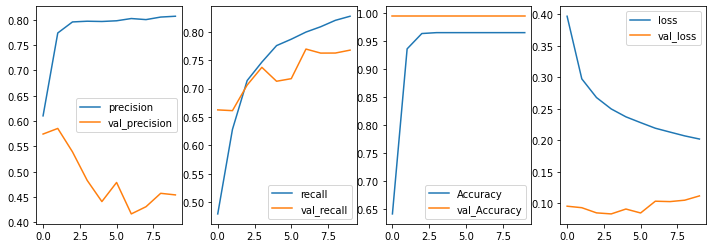

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(hist.history["precision"],label="precision")
plt.plot(hist.history["val_precision"],label="val_precision")
plt.legend()
plt.subplot(1,4,2)
plt.plot(hist.history["recall"],label="recall")
plt.plot(hist.history["val_recall"],label="val_recall")
plt.legend()
plt.subplot(1,4,3)
plt.plot(hist.history["Accuracy"],label="Accuracy")
plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
plt.legend();
plt.subplot(1,4,4)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend();

In [35]:
predictions=model_biLSTM.predict(pad_X_test)

1496/1496 [==============================] - 157s 104ms/step


In [36]:
print(multilabel_confusion_matrix(Y_test,np.round(predictions)))

[[[36004  7286]
  [  326  4256]]

 [[47385     1]
  [  483     3]]

 [[44141  1175]
  [  422  2134]]

 [[47736     0]
  [  136     0]]

 [[44181  1302]
  [  659  1730]]

 [[47440     0]
  [  432     0]]]


In [37]:
print(classification_report(Y_test,np.round(predictions)))

              precision    recall  f1-score   support

           0       0.37      0.93      0.53      4582
           1       0.75      0.01      0.01       486
           2       0.64      0.83      0.73      2556
           3       0.00      0.00      0.00       136
           4       0.57      0.72      0.64      2389
           5       0.00      0.00      0.00       432

   micro avg       0.45      0.77      0.57     10581
   macro avg       0.39      0.42      0.32     10581
weighted avg       0.48      0.77      0.55     10581
 samples avg       0.08      0.08      0.08     10581



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
def get_labels(y):
  from random import randrange
  index=randrange(len(y))
  labels=[]
  if sum(y[index])==0:
    labels.append("safe comment")

  for i in range(5):
    if y[index][i]==1 and i==0:
      labels.append("toxic")
    elif y[index][i]==1 and i==1:
      labels.append("severe toxic")
    elif y[index][i]==1 and i==2:
      labels.append("obscene")
    elif y[index][i]==1 and i==3:
      labels.append("threat")
    elif y[index][i]==1 and i==4:
      labels.append("insult")
    elif y[index][i]==1 and i==5:
      labels.append("identity hate")

  return labels,index

In [39]:
np.round(predictions)

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [40]:
#examples...
output_word=""
while output_word!="stop":
  print(X_test[get_labels(Y_test)[1]])
  print('\033[1m' + "Predicted type of comment" + '\033[0m', get_labels(np.round(predictions))[0])
  print('\033[1m' + "Actual type of comment" + '\033[0m', get_labels(Y_test)[0])
  print('\n******************************************************************')

  output_word=input("Type any key to show predictions for a random toxic comment, otherwise type STOP: ").lower()


wp mos image recommend lead image small px make image small user set px user preference hesperian
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
agree talk contrib
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
sockpuppetry case accuse sockpuppetry please refer wikipedia suspect sock puppet cretanpride th evidence please make sure make familiar note suspect edit evidence page
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
good job dark

# *CONCLUSIONS*

Evaluated Precision, Recall and Accuracy: 

*   Precision and Recall are better for comprehending how much comments are 
classified respectively as false positives and false negatives;
*   with an high imbalanced dataframe Accuracy would not be a good metric (it could reach high values just because the model gets trained to classify everything as belonging to the majority class);
*   Accuracy may still be good to comprehend if too much noise is present in the dataset creating possible overfitting (accuracy decreases)



Downsampling the majority class (clean comments) the model reaches a decent value of Recall, but a bad value of Precision. Personally, I find more important to have a high value of Recall, since it may be better to minimize the toxic comments being wrongly classified as non toxic. Said this, we should try to reach a higher value of Precision too: it's not acceptable to have a Precision lower than 0.5! Moreover, the less populated labels (severe toxic, threat and identity hate) are all miscalssified...

# **2° CASE: OVERSAMPLING TOXIC TRAIN DATA**

In [41]:
#dataset split
X_train,X_test,Y_train,Y_test=train_test_split(comments,toxic_comments_labels,test_size=.3,random_state=42)

In [42]:
#creation of train dataframe
data_train=pd.DataFrame({'comment_texts':X_train, 
                         "toxic":Y_train[:,0],	
                         "severe_toxic":Y_train[:,1],	
                         "obscene":Y_train[:,2],	
                         "threat":Y_train[:,3],	
                         "insult":Y_train[:,4],	
                         "identity_hate":Y_train[:,5]
                         })
data_train["sum_injurious"]=data_train.drop(["comment_texts"],axis=1).sum(axis=1)

In [43]:
#creation of clean comments and toxic comments dataframe
data_train_clean=data_train[data_train["sum_injurious"]==0].drop(["sum_injurious"],axis=1)
data_train_toxic=data_train[data_train["sum_injurious"]!=0].drop(["sum_injurious"],axis=1)

In [44]:
data_train_toxic_oversampled = resample(data_train_toxic,
                                  replace=True,
                                  n_samples=25000,random_state=42
                            )
data_train=pd.concat([data_train_clean,data_train_toxic_oversampled])
data_train=data_train.sample(frac=1).reset_index(drop=True)

In [45]:
X_train=data_train.comment_texts.values
Y_train=data_train.drop(["comment_texts"],axis=1).values

In [46]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [47]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

# *MODEL CONSTRUCTION*

In [48]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,128,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(128,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(16,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(6,activation="sigmoid"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          16106624  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         263168    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          8224      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                51216     
                                                                 
 dropout (Dropout)           (None, 16)                0

In [49]:
callback = EarlyStopping(monitor='val_loss', patience=4)   
model_biLSTM.compile(optimizer="adam",loss="binary_crossentropy",metrics=["Precision","Recall","Accuracy"])
hist=model_biLSTM.fit(pad_X_train,Y_train,batch_size=64, verbose=1, validation_data=(pad_X_test,Y_test), epochs=12, callbacks=callback)

Epoch 1/12
1959/1959 [==============================] - 1323s 673ms/step - loss: 0.1331 - precision: 0.6919 - recall: 0.5077 - Accuracy: 0.8407 - val_loss: 0.0548 - val_precision: 0.8173 - val_recall: 0.6260 - val_Accuracy: 0.9940
Epoch 2/12
1959/1959 [==============================] - 1332s 680ms/step - loss: 0.0886 - precision: 0.8278 - recall: 0.6587 - Accuracy: 0.9885 - val_loss: 0.0603 - val_precision: 0.7680 - val_recall: 0.6796 - val_Accuracy: 0.9940
Epoch 3/12
1959/1959 [==============================] - 1341s 684ms/step - loss: 0.0780 - precision: 0.8335 - recall: 0.7006 - Accuracy: 0.9872 - val_loss: 0.0659 - val_precision: 0.7660 - val_recall: 0.6687 - val_Accuracy: 0.9940
Epoch 4/12
1959/1959 [==============================] - 1356s 692ms/step - loss: 0.0704 - precision: 0.8376 - recall: 0.7360 - Accuracy: 0.9865 - val_loss: 0.0829 - val_precision: 0.7751 - val_recall: 0.6427 - val_Accuracy: 0.9940
Epoch 5/12
1959/1959 [==============================] - 1343s 686ms/step - l

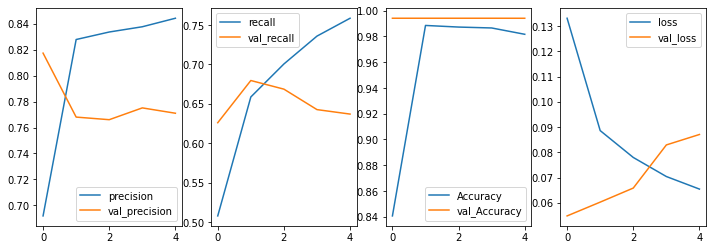

In [50]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(hist.history["precision"],label="precision")
plt.plot(hist.history["val_precision"],label="val_precision")
plt.legend()
plt.subplot(1,4,2)
plt.plot(hist.history["recall"],label="recall")
plt.plot(hist.history["val_recall"],label="val_recall")
plt.legend()
plt.subplot(1,4,3)
plt.plot(hist.history["Accuracy"],label="Accuracy")
plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
plt.legend();
plt.subplot(1,4,4)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend();

In [51]:
predictions=model_biLSTM.predict(pad_X_test)

1496/1496 [==============================] - 162s 108ms/step


In [52]:
print(multilabel_confusion_matrix(Y_test,np.round(predictions)))

[[[42208  1082]
  [ 1127  3455]]

 [[47372    14]
  [  463    23]]

 [[44941   375]
  [  695  1861]]

 [[47736     0]
  [  136     0]]

 [[44952   531]
  [  988  1401]]

 [[47440     0]
  [  432     0]]]


In [53]:
print(classification_report(Y_test,np.round(predictions)))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      4582
           1       0.62      0.05      0.09       486
           2       0.83      0.73      0.78      2556
           3       0.00      0.00      0.00       136
           4       0.73      0.59      0.65      2389
           5       0.00      0.00      0.00       432

   micro avg       0.77      0.64      0.70     10581
   macro avg       0.49      0.35      0.38     10581
weighted avg       0.72      0.64      0.67     10581
 samples avg       0.07      0.06      0.06     10581



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
def get_labels(y):
  from random import randrange
  index=randrange(len(y))
  labels=[]
  if sum(y[index])==0:
    labels.append("safe comment")

  for i in range(5):
    if y[index][i]==1 and i==0:
      labels.append("toxic")
    elif y[index][i]==1 and i==1:
      labels.append("severe toxic")
    elif y[index][i]==1 and i==2:
      labels.append("obscene")
    elif y[index][i]==1 and i==3:
      labels.append("threat")
    elif y[index][i]==1 and i==4:
      labels.append("insult")
    elif y[index][i]==1 and i==5:
      labels.append("identity hate")

  return labels,index

In [55]:
np.round(predictions)

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [57]:
#examples...
output_word=""
while output_word!="stop":
  print(X_test[get_labels(Y_test)[1]])
  print('\033[1m' + "Predicted type of comment" + '\033[0m', get_labels(np.round(predictions))[0])
  print('\033[1m' + "Actual type of comment" + '\033[0m', get_labels(Y_test)[0])
  print('\n******************************************************************')

  output_word=input("Type any key to show predictions for a random toxic comment, otherwise type STOP: ").lower()


early career devise succession puzzle read cecil responsible illegal document happen read biography cecil northumberland write quite specific rewrote paragraph cite source hope one credible account incident find case aspect reign add perspective illumunate nature cecil courage scroll principle would retreat duress either interest state preserve
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
thank experiment wikipedia test work revert remove please use sandbox test may want take look welcome page learn contribute encyclopedia
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
bribery mexico pfizer serious accusation alongsi

# *CONCLUSIONS*


Oversampling the minority class (toxic comments) the model reaches a higher value of Precision, but a lower value of Recall. Not so good. Same problem on less populated labels is evident too. Let's try to oversample only these specific labels...

# **3° CASE: OVERSAMPLING TOXIC TRAIN DATA - LABEL SENSITIVE**




In [31]:
#dataset split
X_train,X_test,Y_train,Y_test=train_test_split(comments,toxic_comments_labels,test_size=.3,random_state=42)

In [32]:
#creation of train dataframe
data_train=pd.DataFrame({'comment_texts':X_train, 
                         "toxic":Y_train[:,0],	
                         "severe_toxic":Y_train[:,1],	
                         "obscene":Y_train[:,2],	
                         "threat":Y_train[:,3],	
                         "insult":Y_train[:,4],	
                         "identity_hate":Y_train[:,5]
                         })
data_train["sum_injurious"]=data_train.drop(["comment_texts"],axis=1).sum(axis=1)

In [33]:
#creation of clean comments and toxic comments dataframe
data_train_clean=data_train[data_train["sum_injurious"]==0].drop(["sum_injurious"],axis=1)
data_train_toxic=data_train[data_train["sum_injurious"]!=0].drop(["sum_injurious"],axis=1)

In [34]:
data_train_toxic_oversampled = resample(data_train_toxic[data_train_toxic["toxic"]==1],
                                  replace=True,
                                  n_samples=10000,random_state=42
                            )
data_train_severe_toxic_oversampled = resample(data_train_toxic[data_train_toxic["severe_toxic"]==1],
                                  replace=True,
                                  n_samples=6000,random_state=42
                            )
data_train_obscene_oversampled = resample(data_train_toxic[data_train_toxic["obscene"]==1],
                                  replace=True,
                                  n_samples=10000,random_state=42
                            ) 
data_train_threat_oversampled = resample(data_train_toxic[data_train_toxic["threat"]==1],
                                  replace=True,
                                  n_samples=6000,random_state=42
                            )
data_train_insult_oversampled = resample(data_train_toxic[data_train_toxic["insult"]==1],
                                  replace=True,
                                  n_samples=10000,random_state=42
                            )   
data_train_identity_hate_oversampled = resample(data_train_toxic[data_train_toxic["identity_hate"]==1],
                                  replace=True,
                                  n_samples=6000,random_state=42
                            )  
data_train=pd.concat([data_train_clean,data_train_toxic_oversampled,
                      data_train_severe_toxic_oversampled,data_train_obscene_oversampled,
                      data_train_threat_oversampled,data_train_insult_oversampled,
                      data_train_identity_hate_oversampled])
data_train=data_train.sample(frac=1).reset_index(drop=True)

In [35]:
X_train=data_train.comment_texts.values
Y_train=data_train.drop(["comment_texts"],axis=1).values

In [36]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [37]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

# *MODEL CONSTRUCTION*

In [38]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,128,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(128,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(16,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(6,activation="sigmoid"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          16060544  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         263168    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          8224      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                51216     
                                                                 
 dropout (Dropout)           (None, 16)                0

In [39]:
callback = EarlyStopping(monitor='val_loss', patience=5)  
model_biLSTM.compile(optimizer="adam",loss="binary_crossentropy",metrics=["Precision","Recall","Accuracy"])
hist=model_biLSTM.fit(pad_X_train,Y_train,batch_size=96, verbose=1, validation_data=(pad_X_test,Y_test), epochs=15, callbacks=callback)

Epoch 1/15
1546/1546 [==============================] - 1348s 869ms/step - loss: 0.2040 - precision: 0.8106 - recall: 0.6926 - Accuracy: 0.8089 - val_loss: 0.0610 - val_precision: 0.7006 - val_recall: 0.7417 - val_Accuracy: 0.9940
Epoch 2/15
1546/1546 [==============================] - 1358s 879ms/step - loss: 0.1459 - precision: 0.8507 - recall: 0.7608 - Accuracy: 0.9710 - val_loss: 0.0710 - val_precision: 0.7356 - val_recall: 0.7021 - val_Accuracy: 0.9936
Epoch 3/15
1546/1546 [==============================] - 1349s 873ms/step - loss: 0.1282 - precision: 0.8530 - recall: 0.7957 - Accuracy: 0.9751 - val_loss: 0.0740 - val_precision: 0.7370 - val_recall: 0.7067 - val_Accuracy: 0.9940
Epoch 4/15
1546/1546 [==============================] - 1352s 874ms/step - loss: 0.1183 - precision: 0.8571 - recall: 0.8131 - Accuracy: 0.9618 - val_loss: 0.0893 - val_precision: 0.7113 - val_recall: 0.7134 - val_Accuracy: 0.9939
Epoch 5/15
1546/1546 [==============================] - 1365s 883ms/step - l

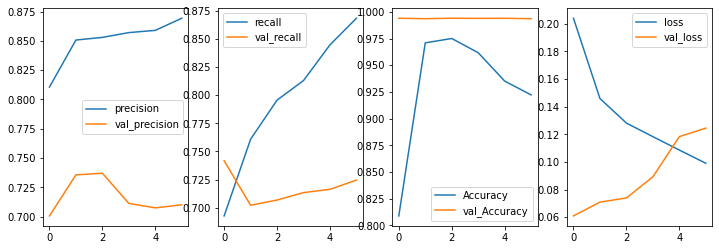

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(hist.history["precision"],label="precision")
plt.plot(hist.history["val_precision"],label="val_precision")
plt.legend()
plt.subplot(1,4,2)
plt.plot(hist.history["recall"],label="recall")
plt.plot(hist.history["val_recall"],label="val_recall")
plt.legend()
plt.subplot(1,4,3)
plt.plot(hist.history["Accuracy"],label="Accuracy")
plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
plt.legend();
plt.subplot(1,4,4)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend();

In [41]:
predictions=model_biLSTM.predict(pad_X_test)

1496/1496 [==============================] - 173s 115ms/step


In [42]:
print(multilabel_confusion_matrix(Y_test,np.round(predictions)))

[[[42306   984]
  [ 1187  3395]]

 [[47118   268]
  [  262   224]]

 [[44701   615]
  [  506  2050]]

 [[47652    84]
  [   84    52]]

 [[44505   978]
  [  637  1752]]

 [[47239   201]
  [  239   193]]]


In [43]:
print(classification_report(Y_test,np.round(predictions)))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      4582
           1       0.46      0.46      0.46       486
           2       0.77      0.80      0.79      2556
           3       0.38      0.38      0.38       136
           4       0.64      0.73      0.68      2389
           5       0.49      0.45      0.47       432

   micro avg       0.71      0.72      0.72     10581
   macro avg       0.59      0.59      0.59     10581
weighted avg       0.71      0.72      0.72     10581
 samples avg       0.06      0.07      0.06     10581



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
def get_labels(y):
  from random import randrange
  index=randrange(len(y))
  labels=[]
  if sum(y[index])==0:
    labels.append("safe comment")

  for i in range(5):
    if y[index][i]==1 and i==0:
      labels.append("toxic")
    elif y[index][i]==1 and i==1:
      labels.append("severe toxic")
    elif y[index][i]==1 and i==2:
      labels.append("obscene")
    elif y[index][i]==1 and i==3:
      labels.append("threat")
    elif y[index][i]==1 and i==4:
      labels.append("insult")
    elif y[index][i]==1 and i==5:
      labels.append("identity hate")

  return labels,index

In [45]:
np.round(predictions)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [46]:
#examples...
output_word=""
while output_word!="stop":
  print(X_test[get_labels(Y_test)[1]])
  print('\033[1m' + "Predicted type of comment" + '\033[0m', get_labels(np.round(predictions))[0])
  print('\033[1m' + "Actual type of comment" + '\033[0m', get_labels(Y_test)[0])
  print('\n******************************************************************')

  output_word=input("Type any key to show predictions for a random toxic comment, otherwise type STOP: ").lower()


publication chamcha age era stooge write kanshi ram copyright unless someone seem copyright death kanshi ram editor publication oppressed indian issue late early read also opportunity witness address gathering quite occasion feel content moment draw mostly medium report objectively represent individual struggle emancipation downtrodden masse india therefore okay retain first paragraph compile text author chamcha age present web space bspindia org appear close term authentic represent view bahujan samaj party political party found kanshi ram although site claim copyright content formally acknowledge source draw content available without copyright mind write webmaster bspindia org get permission use content site reproduction wikipedia secondly modify article appropriately content bspindia org source use source information instead article content feel strongly page kanshi ram need change appropriately reader get proper perspective life mission usher political change modern india
Predicted

Oversampling label per label (increasing more the less populated labels) gives better results: 72% of Recall and 71% of Precision. Decent results! Let's try to see if it's possible to improve the model...

Good news: the problem of misclassification for the less populated labels is reduced

# **4° CASE: WORDS EMBEDDING**

In [ ]:
#dataset split
X_train,X_test,Y_train,Y_test=train_test_split(comments,toxic_comments_labels,test_size=.3,random_state=42)

In [ ]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

In [ ]:

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz
!ls -l

--2023-01-15 07:45:54--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.173.56, 54.231.234.72, 52.217.129.80, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.173.56|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-01-15 07:45:54 ERROR 404: Not Found.

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory
total 8
drwx------ 5 root root 4096 Jan 15 07:45 drive
drwxr-xr-x 1 root root 4096 Jan  9 14:36 sample_data


In [ ]:
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader
# Load pretrained Glove model (in word2vec form)
word2vec_model=gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#Embedding length based on selected model - we are using 50d here.
embedding_vector_length = 300

#Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_vector_length))
print(embedding_matrix.shape)

for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (vocab_size):
        break
    try:
        embedding_vector = word2vec_model[word] #Reading word's embedding from Glove model for a given word
        embedding_matrix[i] = embedding_vector
    except:
        pass

embedding_matrix

(126512, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19140625, -0.08105469, -0.2890625 , ..., -0.31835938,
        -0.09472656, -0.02819824],
       [ 0.17675781,  0.02929688,  0.01031494, ..., -0.22265625,
        -0.01416016, -0.08935547],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,embedding_vector_length,
                           weights=[embedding_matrix],trainable=False,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(128,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(16,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(6,activation="sigmoid"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          37953600  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          8224      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                51216     
                                                                 
 dropout (Dropout)           (None, 16)                0

In [ ]:
#recall is the most important, I want to minimize the flase negatives (toxic comments that are classified as non toxic)

#class MyCallBack(Callback):
#    def on_epoch_end(self, epoch, logs, **kwargs):
#        if logs["val_recall"] > rec_threshold and logs["val_precision"] > pre_threshold or :
#            print(f"Reached precision > {pre_threshold} and recall > {rec_threshold} on test. Training stopped!")
#            self.model.stop_training=True
#rec_threshold=0.8   
#pre_threshold=0.7 
#my_cb=MyCallBack() 

callback = EarlyStopping(monitor='val_loss', patience=6)   
model_biLSTM.compile(optimizer="adam",loss="binary_crossentropy",metrics=["Precision","Recall","Accuracy"])
hist=model_biLSTM.fit(pad_X_train,Y_train,batch_size=72, verbose=1, validation_data=(pad_X_test,Y_test), epochs=20, callbacks=callback)

Epoch 1/20
1552/1552 [==============================] - 761s 488ms/step - loss: 0.1267 - precision: 0.3450 - recall: 0.2981 - Accuracy: 0.6676 - val_loss: 0.0628 - val_precision: 0.8691 - val_recall: 0.5096 - val_Accuracy: 0.9940
Epoch 2/20
1552/1552 [==============================] - 744s 479ms/step - loss: 0.0772 - precision: 0.7929 - recall: 0.3733 - Accuracy: 0.9870 - val_loss: 0.0582 - val_precision: 0.8441 - val_recall: 0.5680 - val_Accuracy: 0.9940
Epoch 3/20
1552/1552 [==============================] - 752s 485ms/step - loss: 0.0694 - precision: 0.8074 - recall: 0.4309 - Accuracy: 0.9942 - val_loss: 0.0566 - val_precision: 0.8379 - val_recall: 0.5842 - val_Accuracy: 0.9940
Epoch 4/20
1552/1552 [==============================] - 745s 480ms/step - loss: 0.0656 - precision: 0.8123 - recall: 0.4534 - Accuracy: 0.9941 - val_loss: 0.0560 - val_precision: 0.8846 - val_recall: 0.5240 - val_Accuracy: 0.9940
Epoch 5/20
1552/1552 [==============================] - 754s 486ms/step - loss: 

# MODEL CONSTRUCTION

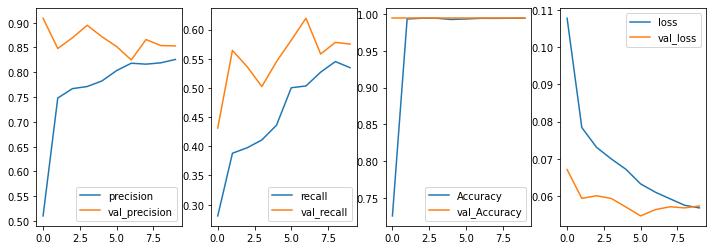

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(hist.history["precision"],label="precision")
plt.plot(hist.history["val_precision"],label="val_precision")
plt.legend()
plt.subplot(1,4,2)
plt.plot(hist.history["recall"],label="recall")
plt.plot(hist.history["val_recall"],label="val_recall")
plt.legend()
plt.subplot(1,4,3)
plt.plot(hist.history["Accuracy"],label="Accuracy")
plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
plt.legend();
plt.subplot(1,4,4)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend();

In [ ]:
predictions=model_biLSTM.predict(pad_X_test)

1496/1496 [==============================] - 138s 92ms/step


In [ ]:
print(multilabel_confusion_matrix(Y_test,np.round(predictions)))

[[[42889   401]
  [ 1505  3077]]

 [[47386     0]
  [  485     1]]

 [[45052   264]
  [  756  1800]]

 [[47736     0]
  [  136     0]]

 [[45100   383]
  [ 1182  1207]]

 [[47440     0]
  [  432     0]]]


In [ ]:
print(classification_report(Y_test,np.round(predictions)))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76      4582
           1       1.00      0.00      0.00       486
           2       0.87      0.70      0.78      2556
           3       0.00      0.00      0.00       136
           4       0.76      0.51      0.61      2389
           5       0.00      0.00      0.00       432

   micro avg       0.85      0.58      0.69     10581
   macro avg       0.59      0.31      0.36     10581
weighted avg       0.81      0.58      0.66     10581
 samples avg       0.06      0.05      0.05     10581



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_labels(y):
  from random import randrange
  index=randrange(len(y))
  labels=[]
  if sum(y[index])==0:
    labels.append("safe comment")

  for i in range(5):
    if y[index][i]==1 and i==0:
      labels.append("toxic")
    elif y[index][i]==1 and i==1:
      labels.append("severe toxic")
    elif y[index][i]==1 and i==2:
      labels.append("obscene")
    elif y[index][i]==1 and i==3:
      labels.append("threat")
    elif y[index][i]==1 and i==4:
      labels.append("insult")
    elif y[index][i]==1 and i==5:
      labels.append("identity hate")

  return labels,index

In [ ]:
np.round(predictions)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:

#examples...
output_word=""
while output_word!="stop":
  print(X_test[get_labels(Y_test)[1]])
  print('\033[1m' + "Predicted type of comment" + '\033[0m', get_labels(np.round(predictions))[0])
  print('\033[1m' + "Actual type of comment" + '\033[0m', get_labels(Y_test)[0])
  print('\n******************************************************************')

  output_word=input("Type any key to show predictions for a random toxic comment, otherwise type STOP: ").lower()


think may key muscle specific bass playing play bass careful use muscle necessary perform specific task involve body tire tendency overuse muscle involve muscle necessary play build muscle specific awareness conserve energy reduce risk injury allow body physically fit play bass international bassist
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
take offense take great offense pompous sanctimonious twit think one allow express appreciation woman like gibson girl fine feature achingly beautiful creature know kind totalitarian feminazi dystopian agenda try foist people encyclopedia base free speech free exchange information bogus political correctness schoolmarmish think police take gibson girl anyday
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

********************

# *CONCLUSIONS*

Using Word2Vec words embedding (similar results have been obtained with Fasttext) Precision increases a lot, unfortunately not Recall... 

The problem of misclassification for the less populated labels remanins compared to Case #1

# **5° CASE: OVERSAMPLING + WORDS EMBEDDING**

In [ ]:
#dataset split
X_train,X_test,Y_train,Y_test=train_test_split(comments,toxic_comments_labels,test_size=.3,random_state=42)

In [ ]:
#creation of train dataframe
data_train=pd.DataFrame({'comment_texts':X_train, 
                         "toxic":Y_train[:,0],	
                         "severe_toxic":Y_train[:,1],	
                         "obscene":Y_train[:,2],	
                         "threat":Y_train[:,3],	
                         "insult":Y_train[:,4],	
                         "identity_hate":Y_train[:,5]
                         })
data_train["sum_injurious"]=data_train.drop(["comment_texts"],axis=1).sum(axis=1)

In [ ]:
#creation of clean comments and toxic comments dataframe
data_train_clean=data_train[data_train["sum_injurious"]==0].drop(["sum_injurious"],axis=1)
data_train_toxic=data_train[data_train["sum_injurious"]!=0].drop(["sum_injurious"],axis=1)

In [ ]:
data_train_toxic_oversampled = resample(data_train_toxic,
                                  replace=True,
                                  n_samples=50000,random_state=42
                            )
data_train=pd.concat([data_train_clean,data_train_toxic_oversampled])
data_train=data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
X_train=data_train.comment_texts.values
Y_train=data_train.drop(["comment_texts"],axis=1).values

In [ ]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz
!ls -l

--2023-01-16 07:12:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.253, 54.231.195.128, 52.217.142.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.253|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-01-16 07:12:09 ERROR 404: Not Found.

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory
total 8
drwx------ 5 root root 4096 Jan 16 07:11 drive
drwxr-xr-x 1 root root 4096 Jan  9 14:36 sample_data


In [ ]:
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader
# Load pretrained Glove model (in word2vec form)
word2vec_model=gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#Embedding length based on selected model
embedding_vector_length = 300

#Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_vector_length))
print(embedding_matrix.shape)

for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (vocab_size):
        break
    try:
        embedding_vector = word2vec_model[word] 
        embedding_matrix[i] = embedding_vector
    except:
        pass

embedding_matrix

(126443, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19140625, -0.08105469, -0.2890625 , ..., -0.31835938,
        -0.09472656, -0.02819824],
       [ 0.17675781,  0.02929688,  0.01031494, ..., -0.22265625,
        -0.01416016, -0.08935547],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07080078, -0.00561523, -0.07470703, ...,  0.19335938,
         0.03710938, -0.01977539],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# *MODEL CONSTRUCTION*

In [ ]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,embedding_vector_length,
                           weights=[embedding_matrix],trainable=False,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(128,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(16,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(6,activation="sigmoid"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          37932900  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          8224      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                51216     
                                                                 
 dropout (Dropout)           (None, 16)                0

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=6)   
model_biLSTM.compile(optimizer="adam",loss="binary_crossentropy",metrics=["Precision","Recall","Accuracy"])
hist=model_biLSTM.fit(pad_X_train,Y_train,batch_size=72, verbose=1, validation_data=(pad_X_test,Y_test), epochs=20, callbacks=callback)

Epoch 1/20
2089/2089 [==============================] - 1394s 665ms/step - loss: 0.2027 - precision: 0.7024 - recall: 0.5338 - Accuracy: 0.8490 - val_loss: 0.0620 - val_precision: 0.7155 - val_recall: 0.7013 - val_Accuracy: 0.9940
Epoch 2/20
2089/2089 [==============================] - 1400s 670ms/step - loss: 0.1585 - precision: 0.7938 - recall: 0.6110 - Accuracy: 0.9809 - val_loss: 0.0621 - val_precision: 0.7195 - val_recall: 0.6854 - val_Accuracy: 0.9940
Epoch 3/20
2089/2089 [==============================] - 1399s 670ms/step - loss: 0.1480 - precision: 0.7936 - recall: 0.6396 - Accuracy: 0.9812 - val_loss: 0.0609 - val_precision: 0.6864 - val_recall: 0.7270 - val_Accuracy: 0.9940
Epoch 4/20
2089/2089 [==============================] - 1418s 679ms/step - loss: 0.1402 - precision: 0.7870 - recall: 0.6942 - Accuracy: 0.9793 - val_loss: 0.0611 - val_precision: 0.6859 - val_recall: 0.7175 - val_Accuracy: 0.9940
Epoch 5/20
2089/2089 [==============================] - 1413s 677ms/step - l

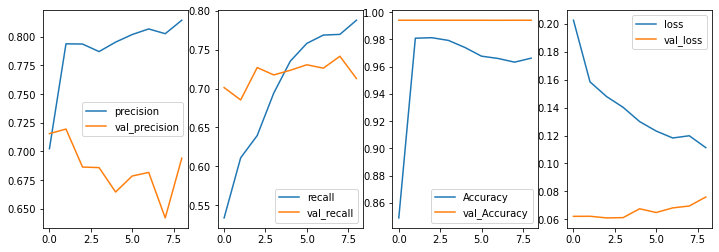

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(hist.history["precision"],label="precision")
plt.plot(hist.history["val_precision"],label="val_precision")
plt.legend()
plt.subplot(1,4,2)
plt.plot(hist.history["recall"],label="recall")
plt.plot(hist.history["val_recall"],label="val_recall")
plt.legend()
plt.subplot(1,4,3)
plt.plot(hist.history["Accuracy"],label="Accuracy")
plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
plt.legend();
plt.subplot(1,4,4)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend();

In [ ]:
predictions=model_biLSTM.predict(pad_X_test)

1496/1496 [==============================] - 214s 142ms/step


In [ ]:
print(multilabel_confusion_matrix(Y_test,np.round(predictions)))

[[[41067  2223]
  [  627  3955]]

 [[47363    23]
  [  449    37]]

 [[44884   432]
  [  568  1988]]

 [[47736     0]
  [  136     0]]

 [[44838   645]
  [  831  1558]]

 [[47439     1]
  [  427     5]]]


In [ ]:
print(classification_report(Y_test,np.round(predictions)))

              precision    recall  f1-score   support

           0       0.64      0.86      0.74      4582
           1       0.62      0.08      0.14       486
           2       0.82      0.78      0.80      2556
           3       0.00      0.00      0.00       136
           4       0.71      0.65      0.68      2389
           5       0.83      0.01      0.02       432

   micro avg       0.69      0.71      0.70     10581
   macro avg       0.60      0.40      0.40     10581
weighted avg       0.70      0.71      0.67     10581
 samples avg       0.08      0.07      0.07     10581



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_labels(y):
  from random import randrange
  index=randrange(len(y))
  labels=[]
  if sum(y[index])==0:
    labels.append("safe comment")

  for i in range(5):
    if y[index][i]==1 and i==0:
      labels.append("toxic")
    elif y[index][i]==1 and i==1:
      labels.append("severe toxic")
    elif y[index][i]==1 and i==2:
      labels.append("obscene")
    elif y[index][i]==1 and i==3:
      labels.append("threat")
    elif y[index][i]==1 and i==4:
      labels.append("insult")
    elif y[index][i]==1 and i==5:
      labels.append("identity hate")

  return labels,index

In [ ]:
np.round(predictions)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
#examples...
output_word=""
while output_word!="stop":
  print(X_test[get_labels(Y_test)[1]])
  print('\033[1m' + "Predicted type of comment" + '\033[0m', get_labels(np.round(predictions))[0])
  print('\033[1m' + "Actual type of comment" + '\033[0m', get_labels(Y_test)[0])
  print('\n******************************************************************')

  output_word=input("Type any key to show predictions for a random toxic comment, otherwise type STOP: ").lower()


abdoreza razmjoo hi sorry know wrong
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
wrong although block occasion never block sockpuppetry vandalism dispute multiple topic various sock user hkelkar user vandalpetrol permabanned never use account permit edit get account delete say indeffe blast
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
see user talk kmweber acc tool point repeat argument talk
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type

# *CONCLUSIONS*

Similar results to Case #3, but with problems of high misclassifications for the less populated labels

## **6° CASE: LABEL SENSITIVE OVERSAMPLING + WORDS EMBEDDING** 



In [19]:
#dataset split
X_train,X_test,Y_train,Y_test=train_test_split(comments,toxic_comments_labels,test_size=.3,random_state=42)

In [20]:
#creation of train dataframe
data_train=pd.DataFrame({'comment_texts':X_train, 
                         "toxic":Y_train[:,0],	
                         "severe_toxic":Y_train[:,1],	
                         "obscene":Y_train[:,2],	
                         "threat":Y_train[:,3],	
                         "insult":Y_train[:,4],	
                         "identity_hate":Y_train[:,5]
                         })
data_train["sum_injurious"]=data_train.drop(["comment_texts"],axis=1).sum(axis=1)

In [21]:
#creation of clean comments and toxic comments dataframe
data_train_clean=data_train[data_train["sum_injurious"]==0]
data_train_toxic=data_train[data_train["sum_injurious"]!=0]

In [22]:
X_train=data_train.comment_texts.values
Y_train=data_train.drop(["comment_texts"],axis=1).values

In [23]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [24]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

In [25]:

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz
!ls -l

--2023-01-18 16:37:59--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.64, 52.216.78.254, 52.216.63.40, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.229.64|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-01-18 16:37:59 ERROR 404: Not Found.

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory
total 8
drwx------ 5 root root 4096 Jan 18 16:37 drive
drwxr-xr-x 1 root root 4096 Jan  9 14:36 sample_data


In [26]:
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader
# Load pretrained Glove model (in word2vec form)
word2vec_model=gensim.downloader.load('word2vec-google-news-300')

[=================================================-] 99.8% 1659.5/1662.8MB downloaded


In [27]:
#Embedding length based on selected modela
embedding_vector_length = 300

#Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_vector_length))

for word, i in sorted(tokenizer.word_index.items(),key=lambda x:x[1]):
    if i > (vocab_size):
        break
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except:
        pass

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19140625, -0.08105469, -0.2890625 , ..., -0.31835938,
        -0.09472656, -0.02819824],
       [ 0.17675781,  0.02929688,  0.01031494, ..., -0.22265625,
        -0.01416016, -0.08935547],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
synonyms_number = 7
word_number = 10000

nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embedding_matrix) 

neighbours_mat = nn.kneighbors(embedding_matrix[1:word_number])[1]
synonyms = {x[0]: x[1:] for x in neighbours_mat}

In [29]:
X_pos_toxic=data_train_toxic.loc[(data_train_toxic["toxic"]==1) & (data_train_toxic["sum_injurious"]==1)]["comment_texts"].values
X_pos_severe_toxic=data_train_toxic.loc[(data_train_toxic["severe_toxic"]==1) & (data_train_toxic["sum_injurious"]==2)]["comment_texts"].values
X_pos_obscene=data_train_toxic.loc[(data_train_toxic["obscene"]==1) & (data_train_toxic["sum_injurious"]==1)]["comment_texts"].values
X_pos_threat=data_train_toxic.loc[(data_train_toxic["threat"]==1) & (data_train_toxic["sum_injurious"]==1)]["comment_texts"].values
X_pos_insult=data_train_toxic.loc[(data_train_toxic["insult"]==1) & (data_train_toxic["sum_injurious"]==1)]["comment_texts"].values
X_pos_identity_hate=data_train_toxic.loc[(data_train_toxic["identity_hate"]==1) & (data_train_toxic["sum_injurious"]==1)]["comment_texts"].values


def modify_sentence(sentence, synonyms, p=0.85):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence


n_texts_toxic=100
indexes_toxic = np.random.randint(0, X_pos_toxic.shape[0], n_texts_toxic)
X_gen_toxic = np.array([modify_sentence(x, synonyms) for x in X_pos_toxic[indexes_toxic]])
Y_gen_toxic = (np.zeros((n_texts_toxic,6)))
Y_gen_toxic[:,0]=1

n_texts_severe_toxic=6000
indexes_severe_toxic = np.random.randint(0, X_pos_severe_toxic.shape[0], n_texts_severe_toxic)
X_gen_severe_toxic = np.array([modify_sentence(x, synonyms) for x in X_pos_severe_toxic[indexes_severe_toxic]])
Y_gen_severe_toxic = (np.zeros((n_texts_severe_toxic,6)))
Y_gen_severe_toxic[:,1]=1

n_texts_obscene=2000
indexes_obscene = np.random.randint(0, X_pos_obscene.shape[0], n_texts_obscene)
X_gen_obscene = np.array([modify_sentence(x, synonyms) for x in X_pos_obscene[indexes_obscene]])
Y_gen_obscene = (np.zeros((n_texts_obscene,6)))
Y_gen_obscene[:,2]=1

n_texts_threat=6000
indexes_threat = np.random.randint(0, X_pos_threat.shape[0], n_texts_threat)
X_gen_threat = np.array([modify_sentence(x, synonyms) for x in X_pos_threat[indexes_threat]])
Y_gen_threat = (np.zeros((n_texts_threat,6)))
Y_gen_threat[:,3]=1

n_texts_insult=3000
indexes_insult = np.random.randint(0, X_pos_insult.shape[0], n_texts_insult)
X_gen_insult = np.array([modify_sentence(x, synonyms) for x in X_pos_insult[indexes_insult]])
Y_gen_insult = (np.zeros((n_texts_insult,6)))
Y_gen_insult[:,4]=1

n_texts_identity_hate=6000
indexes_identity_hate = np.random.randint(0, X_pos_identity_hate.shape[0], n_texts_identity_hate)
X_gen_identity_hate = np.array([modify_sentence(x, synonyms) for x in X_pos_identity_hate[indexes_identity_hate]])
Y_gen_identity_hate = (np.zeros((n_texts_identity_hate,6)))
Y_gen_identity_hate[:,5]=1

In [30]:
#creation of train dataframe
data_gen_toxic=pd.DataFrame({'comment_texts':X_gen_toxic, 
                         "toxic":Y_gen_toxic[:,0],	
                         "severe_toxic":Y_gen_toxic[:,1],	
                         "obscene":Y_gen_toxic[:,2],	
                         "threat":Y_gen_toxic[:,3],	
                         "insult":Y_gen_toxic[:,4],	
                         "identity_hate":Y_gen_toxic[:,5]
                         })
data_gen_severe_toxic=pd.DataFrame({'comment_texts':X_gen_severe_toxic, 
                         "toxic":Y_gen_severe_toxic[:,0],	
                         "severe_toxic":Y_gen_severe_toxic[:,1],	
                         "obscene":Y_gen_severe_toxic[:,2],	
                         "threat":Y_gen_severe_toxic[:,3],	
                         "insult":Y_gen_severe_toxic[:,4],	
                         "identity_hate":Y_gen_severe_toxic[:,5]
                         })
data_gen_obscene=pd.DataFrame({'comment_texts':X_gen_obscene, 
                         "toxic":Y_gen_obscene[:,0],	
                         "severe_toxic":Y_gen_obscene[:,1],	
                         "obscene":Y_gen_obscene[:,2],	
                         "threat":Y_gen_obscene[:,3],	
                         "insult":Y_gen_obscene[:,4],	
                         "identity_hate":Y_gen_obscene[:,5]
                         })
data_gen_threat=pd.DataFrame({'comment_texts':X_gen_threat, 
                         "toxic":Y_gen_threat[:,0],	
                         "severe_toxic":Y_gen_threat[:,1],	
                         "obscene":Y_gen_threat[:,2],	
                         "threat":Y_gen_threat[:,3],	
                         "insult":Y_gen_threat[:,4],	
                         "identity_hate":Y_gen_threat[:,5]
                         })
data_gen_insult=pd.DataFrame({'comment_texts':X_gen_insult, 
                         "toxic":Y_gen_insult[:,0],	
                         "severe_toxic":Y_gen_insult[:,1],	
                         "obscene":Y_gen_insult[:,2],	
                         "threat":Y_gen_insult[:,3],	
                         "insult":Y_gen_insult[:,4],	
                         "identity_hate":Y_gen_insult[:,5]
                         })
data_gen_identity_hate=pd.DataFrame({'comment_texts':X_gen_identity_hate, 
                         "toxic":Y_gen_identity_hate[:,0],	
                         "severe_toxic":Y_gen_identity_hate[:,1],	
                         "obscene":Y_gen_identity_hate[:,2],	
                         "threat":Y_gen_identity_hate[:,3],	
                         "insult":Y_gen_identity_hate[:,4],	
                         "identity_hate":Y_gen_identity_hate[:,5]
                         })

In [31]:
data_gen=pd.concat([data_gen_toxic,data_gen_severe_toxic,
                      data_gen_obscene,data_gen_threat,
                      data_gen_insult,data_gen_identity_hate])
data_train=pd.concat([data_gen,data_train.drop(["sum_injurious"],axis=1)])
data_train=data_train.sample(frac=1).reset_index(drop=True)

In [32]:
X_train=data_train.comment_texts.values
Y_train=data_train.drop(["comment_texts"],axis=1).values

In [33]:
#tokenization of train and test sets
tokenizer=Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [34]:
#padding of train and test sets
pad_X_train = pad_sequences(tok_X_train, maxlen=100,padding="post")
pad_X_test = pad_sequences(tok_X_test, maxlen=100,padding="post")

In [39]:
clear_session()
model_biLSTM=Sequential()
model_biLSTM.add(Embedding(vocab_size,embedding_vector_length,
                           weights=[embedding_matrix],trainable=False,input_length=100))
model_biLSTM.add(Bidirectional(LSTM(128,return_sequences=True,activation="tanh",dropout=0.5)))
model_biLSTM.add(TimeDistributed(Dense(32,activation="relu")))
model_biLSTM.add(Flatten())
model_biLSTM.add(Dense(16,activation="relu"))
model_biLSTM.add(Dropout(.5))
model_biLSTM.add(Dense(6,activation="sigmoid"))
model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          37953600  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 32)          8224      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                51216     
                                                                 
 dropout (Dropout)           (None, 16)                0

In [40]:
callback = EarlyStopping(monitor='val_loss', patience=10)   
model_biLSTM.compile(optimizer="adam",loss="binary_crossentropy",metrics=["Precision","Recall","Accuracy"])
hist=model_biLSTM.fit(pad_X_train,Y_train,batch_size=96, verbose=1, validation_data=(pad_X_test,Y_test), epochs=24, callbacks=callback)

Epoch 1/24
1405/1405 [==============================] - 1123s 796ms/step - loss: 0.1976 - precision: 0.4231 - recall: 0.1990 - Accuracy: 0.4835 - val_loss: 0.0866 - val_precision: 0.8929 - val_recall: 0.2710 - val_Accuracy: 0.9882
Epoch 2/24
1405/1405 [==============================] - 1120s 797ms/step - loss: 0.1126 - precision: 0.8798 - recall: 0.4315 - Accuracy: 0.8504 - val_loss: 0.0817 - val_precision: 0.9312 - val_recall: 0.2840 - val_Accuracy: 0.9931
Epoch 3/24
1405/1405 [==============================] - 1102s 784ms/step - loss: 0.0987 - precision: 0.9033 - recall: 0.4636 - Accuracy: 0.8904 - val_loss: 0.0732 - val_precision: 0.9283 - val_recall: 0.3208 - val_Accuracy: 0.9904
Epoch 4/24
1405/1405 [==============================] - 1118s 796ms/step - loss: 0.0919 - precision: 0.9132 - recall: 0.4656 - Accuracy: 0.8946 - val_loss: 0.0697 - val_precision: 0.8788 - val_recall: 0.4605 - val_Accuracy: 0.9887
Epoch 5/24
1405/1405 [==============================] - 1127s 802ms/step - l

# MODEL CONSTRUCTION

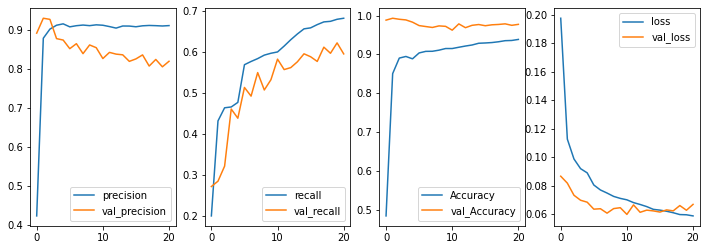

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.plot(hist.history["precision"],label="precision")
plt.plot(hist.history["val_precision"],label="val_precision")
plt.legend()
plt.subplot(1,4,2)
plt.plot(hist.history["recall"],label="recall")
plt.plot(hist.history["val_recall"],label="val_recall")
plt.legend()
plt.subplot(1,4,3)
plt.plot(hist.history["Accuracy"],label="Accuracy")
plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
plt.legend();
plt.subplot(1,4,4)
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="val_loss")
plt.legend();

In [42]:
predictions=model_biLSTM.predict(pad_X_test)

1496/1496 [==============================] - 209s 139ms/step


In [43]:
print(multilabel_confusion_matrix(Y_test,np.round(predictions)))

[[[43034   256]
  [ 1851  2731]]

 [[47375    11]
  [  462    24]]

 [[44848   468]
  [  563  1993]]

 [[47735     1]
  [  136     0]]

 [[44843   640]
  [  838  1551]]

 [[47439     1]
  [  431     1]]]


In [44]:
print(classification_report(Y_test,np.round(predictions)))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      4582
           1       0.69      0.05      0.09       486
           2       0.81      0.78      0.79      2556
           3       0.00      0.00      0.00       136
           4       0.71      0.65      0.68      2389
           5       0.50      0.00      0.00       432

   micro avg       0.82      0.60      0.69     10581
   macro avg       0.60      0.35      0.38     10581
weighted avg       0.80      0.60      0.66     10581
 samples avg       0.05      0.05      0.05     10581



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
def get_labels(y):
  from random import randrange
  index=randrange(len(y))
  labels=[]
  if sum(y[index])==0:
    labels.append("safe comment")

  for i in range(5):
    if y[index][i]==1 and i==0:
      labels.append("toxic")
    elif y[index][i]==1 and i==1:
      labels.append("severe toxic")
    elif y[index][i]==1 and i==2:
      labels.append("obscene")
    elif y[index][i]==1 and i==3:
      labels.append("threat")
    elif y[index][i]==1 and i==4:
      labels.append("insult")
    elif y[index][i]==1 and i==5:
      labels.append("identity hate")

  return labels,index

In [43]:
np.round(predictions)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [44]:
#examples...
output_word=""
while output_word!="stop":
  print(X_test[get_labels(Y_test)[1]])
  print('\033[1m' + "Predicted type of comment" + '\033[0m', get_labels(np.round(predictions))[0])
  print('\033[1m' + "Actual type of comment" + '\033[0m', get_labels(Y_test)[0])
  print('\n******************************************************************')

  output_word=input("Type any key to show predictions for a random toxic comment, otherwise type STOP: ").lower()


redirect talk yes mika nakashima album
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
see comment talk
Predicted type of comment ['safe comment']
Actual type of comment ['safe comment']

******************************************************************
Type any key to show predictions for a random toxic comment, otherwise type STOP: 
welcome hello nauvalridha welcome wikipedia thank contribution hope like place decide stay page might find helpful five pillar wikipedia tutorial edit page develop article create first article use article wizard wish manual style hope enjoy edit wikipedian please sign message discussion page use four tilde automatically insert username date need help check wikipedia question ask talk page ask question page place help question welcome talk•email
Predicted type of comment [

# *CONCLUSIONS*

This last case has a quite stable learning curve, looking at the curves it may be the case with the highest potentiality to reach good Recall and Precision scores. For time reasons I didn't extend the training, but optimizing the hyperparameters this model may be able to reach ca. 80% of Precision and ca. 70% or Recall... 

Without more training on this model I would choose model of case #3